In [2]:
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import pandas as pd 
import sklearn as sk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from scipy.stats import randint, uniform
import xgboost as xgb


In [3]:
# fetch dataset 
online_shoppers_purchasing_intention_dataset = fetch_ucirepo(id=468) 
  
# data (as pandas dataframes) 
X = online_shoppers_purchasing_intention_dataset.data.features 
y = online_shoppers_purchasing_intention_dataset.data.targets 

y = y.astype('int').values.reshape(-1, )
  
# variable information 
print(online_shoppers_purchasing_intention_dataset.variables)

print(X.head())

                       name     role         type demographic description  \
0            Administrative  Feature      Integer        None        None   
1   Administrative_Duration  Feature      Integer        None        None   
2             Informational  Feature      Integer        None        None   
3    Informational_Duration  Feature      Integer        None        None   
4            ProductRelated  Feature      Integer        None        None   
5   ProductRelated_Duration  Feature   Continuous        None        None   
6               BounceRates  Feature   Continuous        None        None   
7                 ExitRates  Feature   Continuous        None        None   
8                PageValues  Feature      Integer        None        None   
9                SpecialDay  Feature      Integer        None        None   
10                    Month  Feature  Categorical        None        None   
11         OperatingSystems  Feature      Integer        None        None   

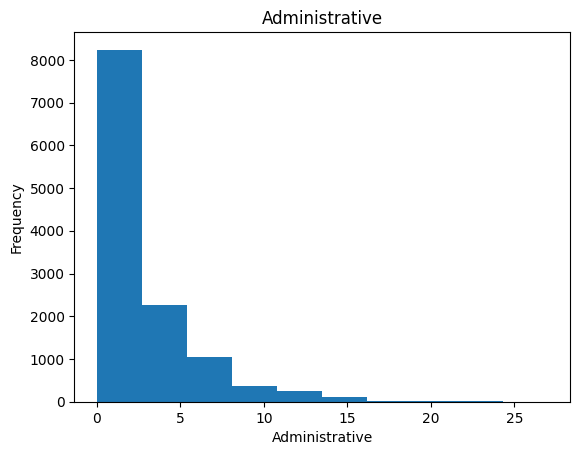

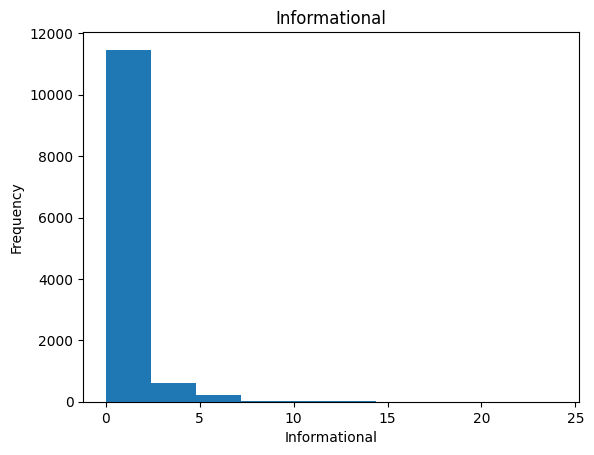

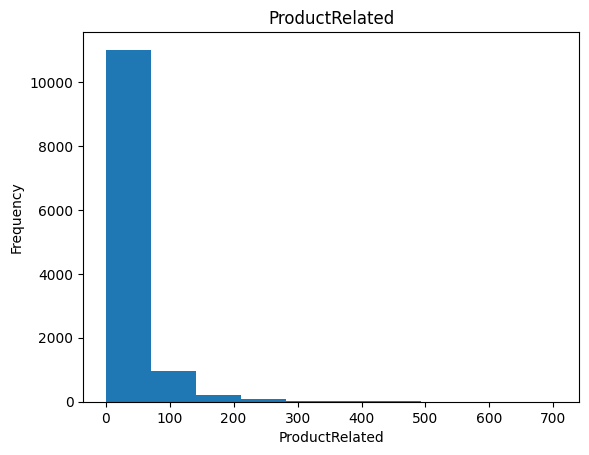

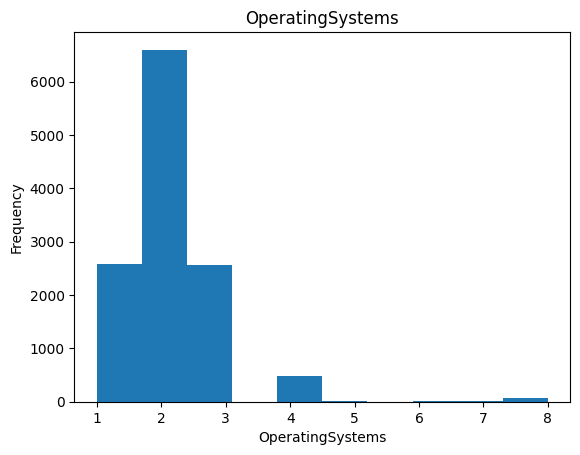

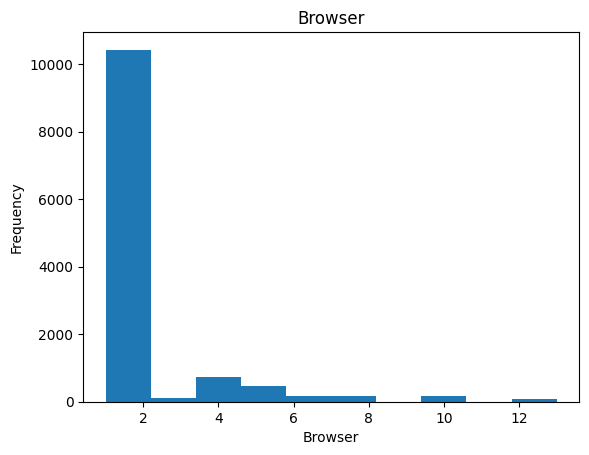

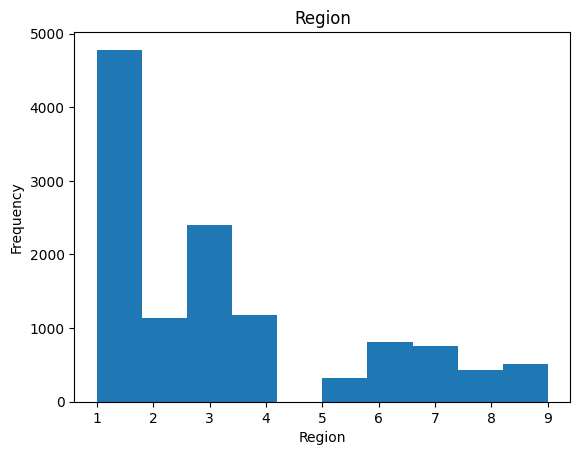

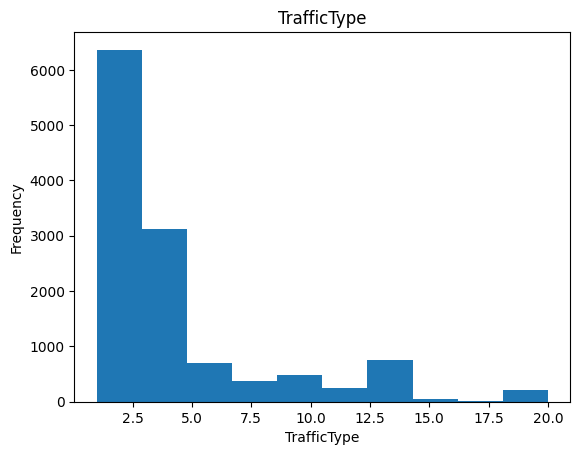

In [4]:
for col in X.columns:
    if pd.api.types.is_integer_dtype(X[col]):
        plt.figure()
        X[col].plot(kind='hist', title=col)
        plt.xlabel(col)
        plt.show()


In [5]:
# Prep data with one-hot encoding and scaling

X_encoded = pd.get_dummies(X, drop_first=True, dtype=int)

scaler = sk.preprocessing.StandardScaler().fit(X_encoded)
X_scaled = scaler.fit_transform(X_encoded)

In [6]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X_scaled, y, test_size=0.2, random_state=42)
logreg = sk.linear_model.LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
mse = sk.metrics.mean_squared_error(y_test, y_pred)
accuracy = sk.metrics.accuracy_score(y_test, y_pred.round())
auc = sk.metrics.roc_auc_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Accuracy:", accuracy)
print("AUC:", auc)

Mean Squared Error: 0.12692619626926196
Accuracy: 0.8730738037307381
AUC: 0.6649635036496351


In [7]:
kf = sk.model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = sk.model_selection.cross_validate(logreg, X_scaled, y, cv=kf, scoring=['accuracy', 'roc_auc'])
print("Cross-validated Accuracy:", cv_results['test_accuracy'])
print("Cross-validated AUC:", cv_results['test_roc_auc'])

Cross-validated Accuracy: [0.8730738  0.89375507 0.88402271 0.88848337 0.88767234]
Cross-validated AUC: [0.89020074 0.89030194 0.89808768 0.89977882 0.89261112]


In [8]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # Use for integer labels
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 5. Evaluate the model (optional)
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# 6. Make predictions (optional)
predictions = model.predict(X_test)

Epoch 1/10


/Users/andrew/school/stat441/OnlinePurchaseRetentionSTAT441/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 602us/step - accuracy: 0.8594 - loss: 0.3386 - val_accuracy: 0.8788 - val_loss: 0.2892
Epoch 2/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.8953 - loss: 0.2571 - val_accuracy: 0.8812 - val_loss: 0.2755
Epoch 3/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - accuracy: 0.9008 - loss: 0.2410 - val_accuracy: 0.8917 - val_loss: 0.2654
Epoch 4/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - accuracy: 0.9034 - loss: 0.2323 - val_accuracy: 0.8852 - val_loss: 0.2750
Epoch 5/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - accuracy: 0.9051 - loss: 0.2251 - val_accuracy: 0.8885 - val_loss: 0.2649
Epoch 6/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - accuracy: 0.9083 - loss: 0.2197 - val_accuracy: 0.8873 - val_loss: 0.2650
Epoch 7/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.9076 - loss: 0.2181 - val_accuracy: 0.8869 - val_loss: 0.2651
Epoch 8/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - accuracy: 0.9105 - loss: 0.2130 - val_accurac

Mean Squared Error from Random Forest: 0.10624493106244931
Accuracy from Random Forest: 0.8937550689375506
AUC from Random Forest: 0.7562043795620438
Precision: 0.7459
Recall: 0.5499
AUC: 0.9194


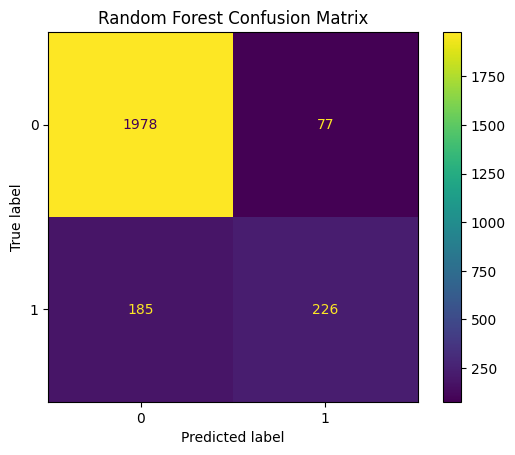

In [16]:
# Random Forest Classification Implementation
randomForest = sk.ensemble.RandomForestClassifier()
randomForest.fit(X_train, y_train)
y_rf = randomForest.predict(X_test) # The predicted y values from our random forest model
rf_mse = sk.metrics.mean_squared_error(y_test, y_rf)
rf_accuracy = sk.metrics.accuracy_score(y_test, y_rf.round())
rf_auc = sk.metrics.roc_auc_score(y_test, y_rf)
print("Mean Squared Error from Random Forest:", rf_mse)
print("Accuracy from Random Forest:", rf_accuracy)
print("AUC from Random Forest:", rf_auc)

y_pred_proba = randomForest.predict_proba(X_test)[:, 1]  # Probability scores for AUC

# Calculate metrics
precision = sk.metrics.precision_score(y_test, y_rf)
recall = sk.metrics.recall_score(y_test, y_rf)
auc = sk.metrics.roc_auc_score(y_test, y_pred_proba)  # Use probabilities, not binary predictions

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")

cm = sk.metrics.confusion_matrix(y_test, y_rf)

sk.metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

In [10]:
# Random forest hyperparameter tuning
parameters = {
  'n_estimators': randint(100, 500),
  'max_depth': randint(3, 15),
  'min_samples_split': randint(2, 10),
  'min_samples_leaf': randint(1, 5)
}

rf = sk.ensemble.RandomForestClassifier(random_state=42, n_jobs=-1)

search = sk.model_selection.RandomizedSearchCV(
  rf, param_distributions=parameters,
  n_iter=10, cv=5, scoring='accuracy',
  n_jobs=-1, random_state=42
)

search.fit(X_train, y_train)
best_rf = search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  search.best_params_)

Best hyperparameters: {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 314}


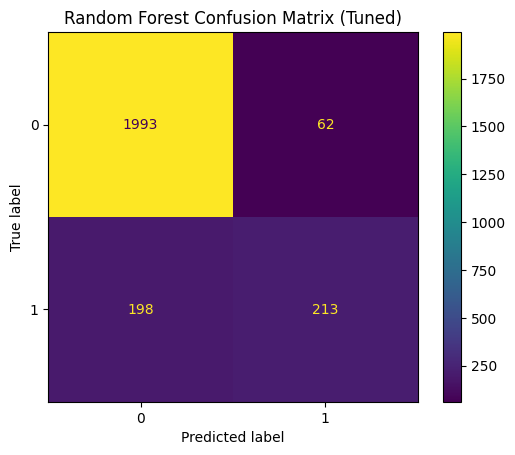

Mean Squared Error from Random Forest: 0.10543390105433902
Accuracy from Random Forest: 0.894566098945661
AUC from Random Forest: 0.7440389294403892
Precision: 0.7745
Recall: 0.5182
AUC: 0.9270


In [17]:
y_best_rf = best_rf.predict(X_test)

# Create the confusion matrix
cm = sk.metrics.confusion_matrix(y_test, y_best_rf)

sk.metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Random Forest Confusion Matrix (Tuned)")
plt.show()

rf_mse = sk.metrics.mean_squared_error(y_test, y_best_rf)
rf_accuracy = sk.metrics.accuracy_score(y_test, y_best_rf.round())
rf_auc = sk.metrics.roc_auc_score(y_test, y_best_rf)
print("Mean Squared Error from Random Forest:", rf_mse)
print("Accuracy from Random Forest:", rf_accuracy)
print("AUC from Random Forest:", rf_auc)

y_pred_proba = best_rf.predict_proba(X_test)[:, 1]  # Probability scores for AUC

# Calculate metrics
precision = sk.metrics.precision_score(y_test, y_best_rf)
recall = sk.metrics.recall_score(y_test, y_best_rf)
auc = sk.metrics.roc_auc_score(y_test, y_pred_proba)  # Use probabilities, not binary predictions

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")

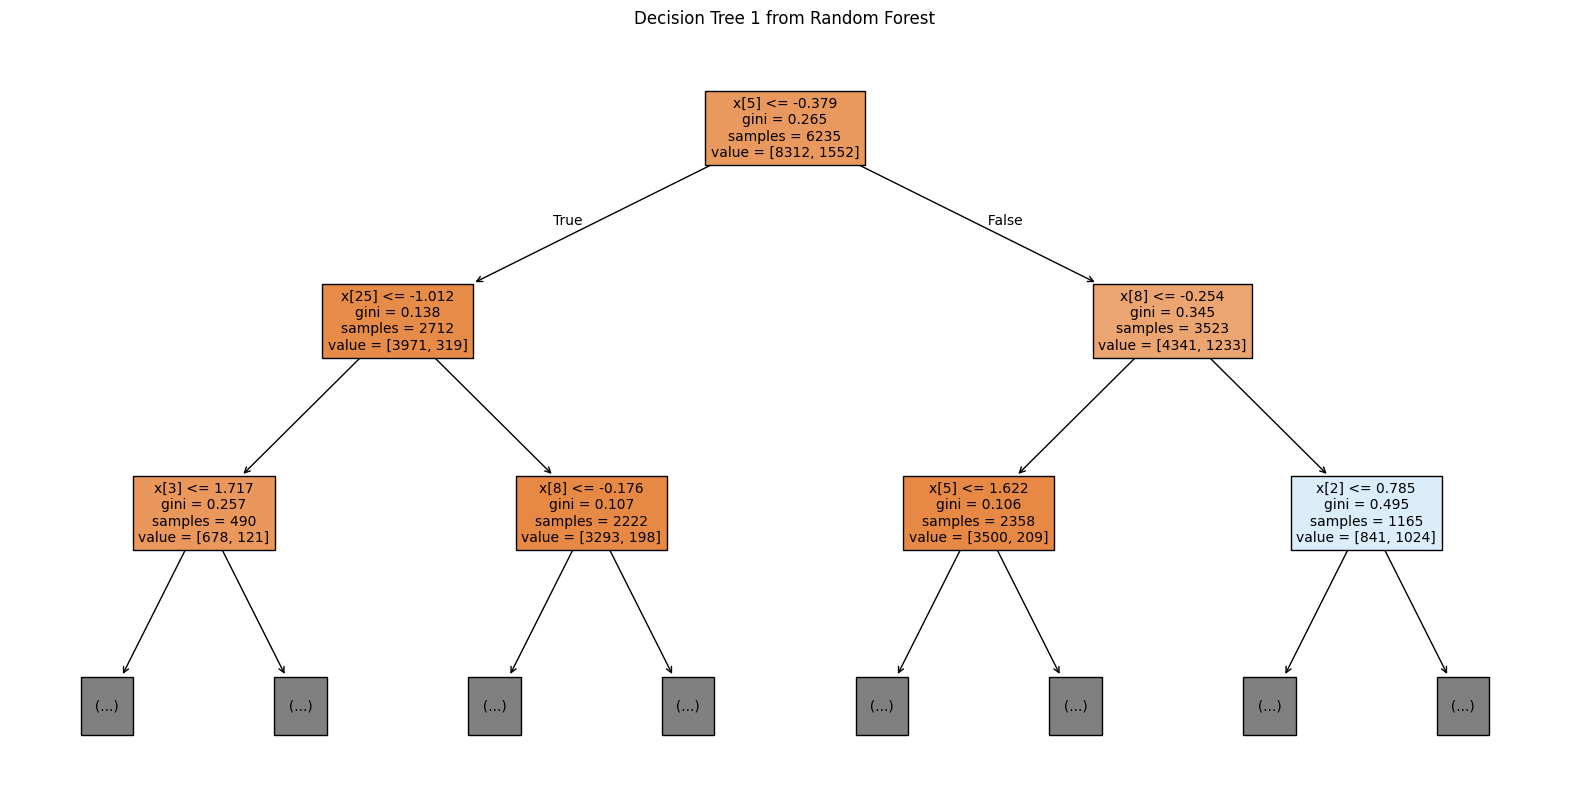

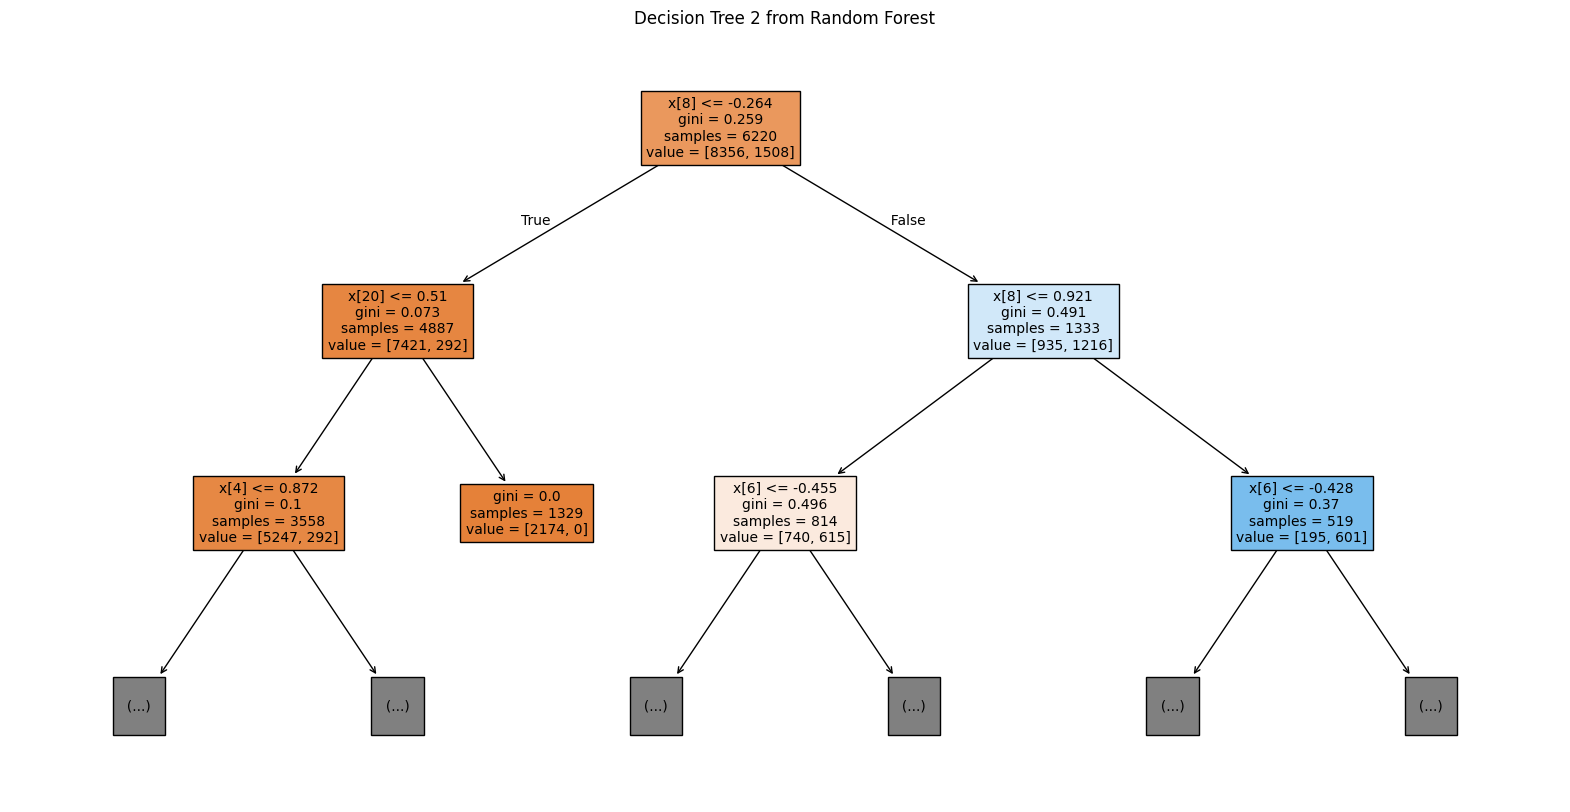

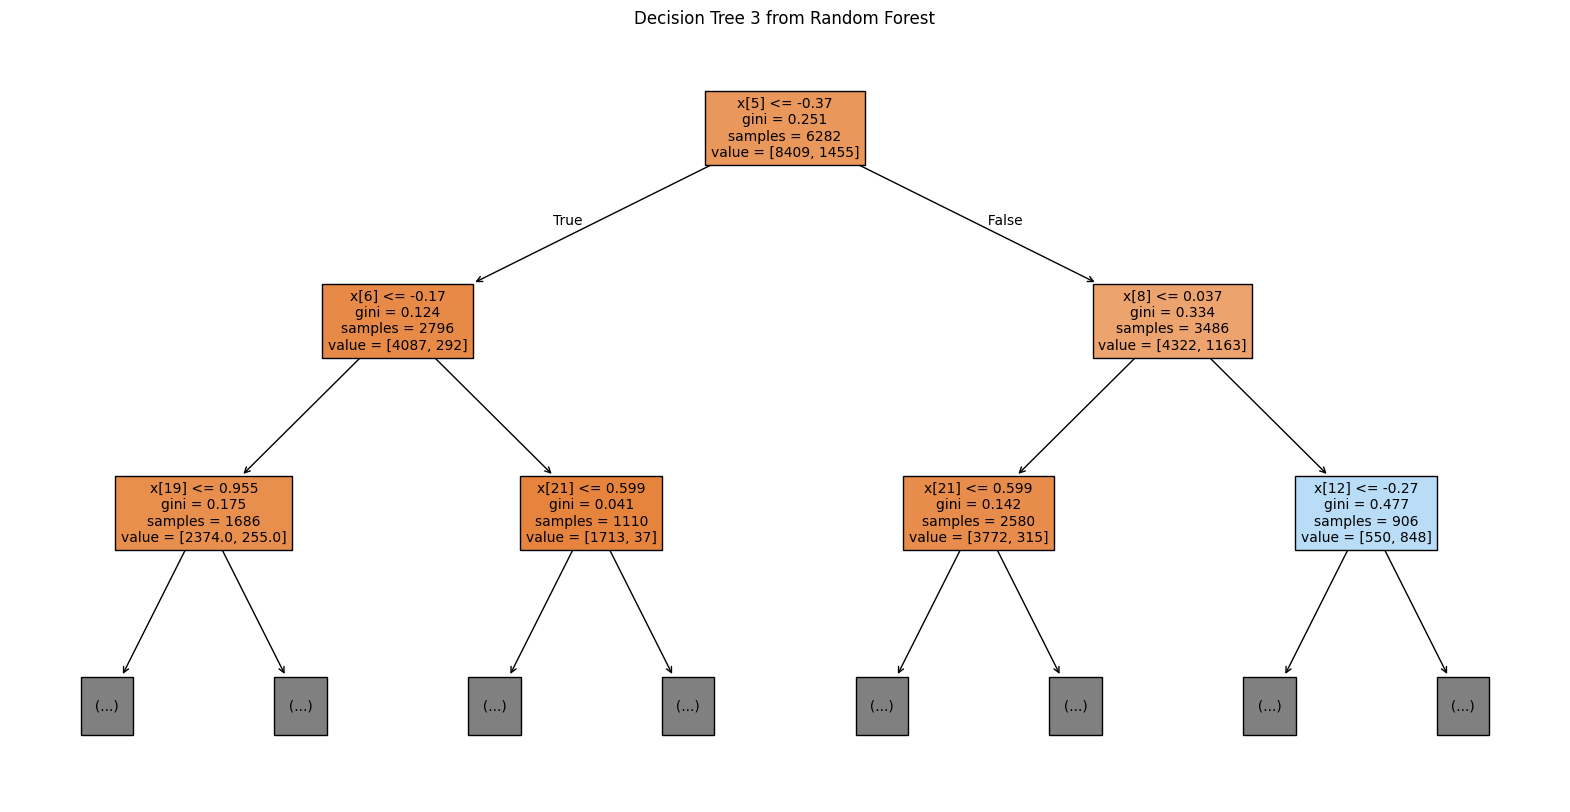

In [12]:
# Display a couple of the decision trees from the forest
for i in range(3):
    tree = best_rf.estimators_[i]
    plt.figure(figsize=(20, 10))
    sk.tree.plot_tree(tree,
                      feature_names=X_train.columns if hasattr(X_train, 'columns') else None,
                      filled=True,
                      max_depth=2,
                      fontsize=10)
    plt.title(f"Decision Tree {i+1} from Random Forest")
    plt.show()

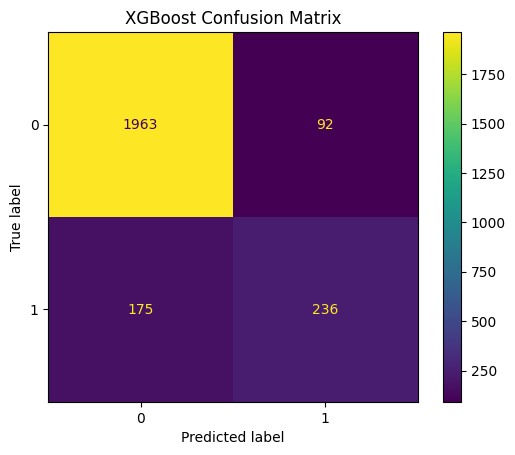

Mean Squared Error from XGBoost: 0.10827250608272507
Accuracy from XGBoost: 0.8917274939172749
AUC from XGBoost: 0.764720194647202
Precision: 0.7195
Recall: 0.5742
AUC: 0.9151


In [18]:
# XGBoost Model
xgb_model = xgb.XGBClassifier(random_state=42, n_jobs=-1)

xgb_model.fit(X_train, y_train)

y_xgb = xgb_model.predict(X_test)

# Create confusion matrix
cm_xgb = sk.metrics.confusion_matrix(y_test, y_xgb)
sk.metrics.ConfusionMatrixDisplay(confusion_matrix=cm_xgb).plot()
plt.title("XGBoost Confusion Matrix")
plt.show()

xgb_mse = sk.metrics.mean_squared_error(y_test, y_xgb)
xgb_accuracy = sk.metrics.accuracy_score(y_test, y_xgb)
xgb_auc = sk.metrics.roc_auc_score(y_test, y_xgb)

print("Mean Squared Error from XGBoost:", xgb_mse)
print("Accuracy from XGBoost:", xgb_accuracy)
print("AUC from XGBoost:", xgb_auc)

y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # Probability scores for AUC

# Calculate metrics
precision = sk.metrics.precision_score(y_test, y_xgb)
recall = sk.metrics.recall_score(y_test, y_xgb)
auc = sk.metrics.roc_auc_score(y_test, y_pred_proba)  # Use probabilities, not binary predictions

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")

In [ ]:
# Hyperparameter Tuning for XGBoost
xgb_parameters = {
    'n_estimators': randint(100, 501),
    'max_depth': randint(3, 11),
    'learning_rate': uniform(0.01, 0.29), 
    'subsample': uniform(0.6, 0.4), 
    'colsample_bytree': uniform(0.6, 0.4)
}

xgb_clf = xgb.XGBClassifier(random_state=42, n_jobs=-1)
xgb_search = sk.model_selection.RandomizedSearchCV(
    xgb_clf, param_distributions=xgb_parameters,
    n_iter=10, cv=5, scoring='accuracy',
    n_jobs=-1, random_state=42
)

xgb_search.fit(X_train, y_train)

best_xgb = xgb_search.best_estimator_
print('Best XGBoost hyperparameters:', xgb_search.best_params_)

y_best_xgb = best_xgb.predict(X_test)

cm_xgb = sk.metrics.confusion_matrix(y_test, y_best_xgb)
sk.metrics.ConfusionMatrixDisplay(confusion_matrix=cm_xgb).plot()
plt.title("XGBoost Confusion Matrix (Tuned)")
plt.show()

xgb_mse = sk.metrics.mean_squared_error(y_test, y_best_xgb)
xgb_accuracy = sk.metrics.accuracy_score(y_test, y_best_xgb)
xgb_auc = sk.metrics.roc_auc_score(y_test, y_best_xgb)

print("Mean Squared Error from XGBoost:", xgb_mse)
print("Accuracy from XGBoost:", xgb_accuracy)
print("AUC from XGBoost:", xgb_auc)

y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]  # Probability scores for AUC

# Calculate metrics
precision = sk.metrics.precision_score(y_test, y_best_xgb)
recall = sk.metrics.recall_score(y_test, y_best_xgb)
auc = sk.metrics.roc_auc_score(y_test, y_pred_proba)  # Use probabilities, not binary predictions

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")